In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Dropout, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import initializers
from tensorflow.keras.layers import add, concatenate
%matplotlib inline  
import warnings
warnings.filterwarnings('ignore')
from keras.callbacks import EarlyStopping, ModelCheckpoint
from scipy.sparse import csr_matrix
import tensorflow as tf
from tensorflow.python.keras.models import model_from_json
from sklearn import preprocessing
from keras.utils.vis_utils import plot_model

## Data Preprocessing

In [2]:
df = pd.read_csv('ml1m_ratings.csv',sep=',', encoding='latin-1', 
                      usecols=['user_emb_id', 'movie_emb_id', 'rating', 'timestamp'])

#+1 is the real size, as they are zero based
num_users = df['user_emb_id'].unique().max() + 1
num_movies = df['movie_emb_id'].unique().max() + 1
df.head(5)

,user_emb_id,movie_emb_id,rating,timestamp
0,0,1192,5,978300760
1,0,660,3,978302109
2,0,913,3,978301968
3,0,3407,4,978300275
4,0,2354,5,978824291


In [3]:
df.iloc[:,0]

0             0
1             0
2             0
3             0
4             0
           ... 
1000204    6039
1000205    6039
1000206    6039
1000207    6039
1000208    6039
Name: user_emb_id, Length: 1000209, dtype: int64

In [4]:
df['user_emb_id']

0             0
1             0
2             0
3             0
4             0
           ... 
1000204    6039
1000205    6039
1000206    6039
1000207    6039
1000208    6039
Name: user_emb_id, Length: 1000209, dtype: int64

In [5]:
df = df.dropna()

In [6]:
train_df, test_df, y_train, y_test = train_test_split(df,df['user_emb_id'],test_size=0.1,random_state=650)  

In [7]:
train_df.head(5)

,user_emb_id,movie_emb_id,rating,timestamp
11457,87,1202,5,977695689
247972,1495,2010,3,974753980
465991,2872,497,1,972782881
475712,2917,1244,5,999802429
456472,2809,3896,4,997248505


In [8]:
train_df, validate_df, xx,yy = train_test_split(train_df,
                                 train_df['user_emb_id'],
                                 test_size=0.1,
                                 random_state=999613182)  

In [9]:
def dataPreprocessor(rating_df, num_users, num_items, init_value=0, average=False):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
    """
    if average:
      matrix = np.full((num_users, num_items), 0.0)
      for (_, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID, itemID] = rating
      avergae = np.true_divide(matrix.sum(1), np.maximum((matrix!=0).sum(1), 1))
      inds = np.where(matrix == 0)
      matrix[inds] = np.take(avergae, inds[0])
      
    else:
      matrix = np.full((num_users, num_items), init_value)
      for (_, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID, itemID] = rating

    return matrix

In [10]:
# Creating a sparse pivot table with users in rows and items in columns
users_items_matrix_train_zero = dataPreprocessor(train_df, num_users, num_movies, 0)
users_items_matrix_train_one = dataPreprocessor(train_df, num_users, num_movies, 1)
users_items_matrix_train_two = dataPreprocessor(train_df, num_users, num_movies, 2)
users_items_matrix_train_four = dataPreprocessor(train_df, num_users, num_movies, 4)
users_items_matrix_train_three = dataPreprocessor(train_df, num_users, num_movies, 3)
users_items_matrix_train_five = dataPreprocessor(train_df, num_users, num_movies, 5)
users_items_matrix_validate = dataPreprocessor(validate_df, num_users, num_movies, 0)
users_items_matrix_test = dataPreprocessor(test_df, num_users, num_movies, 0)

In [11]:
users_items_matrix_train_average = dataPreprocessor(train_df, num_users, num_movies, average=True)

## Utility Function

In [12]:
def show_error(history, skip):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(np.arange(skip, len(loss), 1), loss[skip:])
    plt.plot(np.arange(skip, len(loss), 1), val_loss[skip:])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

In [13]:
def show_rmse(history, skip):
    rmse = history.history['masked_rmse_clip']
    val_rmse = history.history['val_masked_rmse_clip']
    plt.plot(np.arange(skip, len(rmse), 1), rmse[skip:])
    plt.plot(np.arange(skip, len(val_rmse), 1), val_rmse[skip:])
    plt.title('model train vs validation masked_rmse')
    plt.ylabel('rmse')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

In [14]:
def load_model(name):
  # load json and create model
  model_file = open('{}.json'.format(name), 'r')
  loaded_model_json = model_file.read()
  model_file.close()
  loaded_model = model_from_json(loaded_model_json)
  # load weights into new model
  loaded_model.load_weights("{}.h5".format(name))
  print("Loaded model from disk")
  return loaded_model
  

In [15]:
def save_model(name, model):
  # # serialize model to JSON
  model_json = model.to_json()
  with open("{}.json".format(name), "w") as json_file:
      json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights("{}.h5".format(name))
  print("Saved model to disk")

In [16]:
def masked_se(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1)
        return masked_mse

In [17]:
def masked_mse(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1)
        return masked_mse

In [18]:
def masked_rmse(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse

In [19]:
def masked_rmse_clip(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        y_pred = K.clip(y_pred, 1, 5)
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse

In [20]:
# Test custom cost function
y_pred = K.constant([[ 1, 1, 1, 1], 
                     [ 1, 1, 1, 10],
                     [ 1, 1, 1, 3],
                     [ 1, 1, 1, 3],
                     [ 1, 1, 1, 3],
                     [ 1, 1, 1, 3]])
y_pred = K.constant([[ 1, 1, 1, 3]])
y_true = K.constant([[ 1, 1, 1, 1],
                     [ 1, 1, 1, 1],
                     [ 0, 1, 1, 1],
                     [ 0, 0, 1, 1],
                     [ 0, 0, 0, 1],
                     [ 0, 0, 0, 0]])
y_true = K.constant([[ 0, 0, 1, 1]])
true = K.eval(y_true)
pred = K.eval(y_pred)
loss = K.eval(masked_se(y_true, y_pred))
rmse = K.eval(masked_rmse(y_true, y_pred))

for i in range(true.shape[0]):
    print(true[i], pred[i], loss[i], rmse[i], sep='\t')

[0. 0. 1. 1.]	[1. 1. 1. 3.]	4.0	1.4142135


## AutoRec

In [54]:
def AutoRec(X, reg, first_activation, last_activation):
    '''
    AutoRec
        INPUT: 
          X: #_user X #_item matrix
          reg: L2 regularization parameter
          first_activation: activation function for first dense layer
          last_activation: activation function for second dense layer
        
        OUTPUT:
          Keras model
    
    '''
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    x = Dense(500, activation=first_activation, name='LatentSpace', kernel_regularizer=regularizers.l2(reg))(x)
    output_layer = Dense(X.shape[1], activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(reg))(x)
    model = Model(input_layer, output_layer)

    return model

In [22]:
def AutoRec_LReLU(X, reg):
    '''
    AutoRec
    LReLu is not implemented in to Dense 
    Need to have seperate LeakyRelu layer 
    '''
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    x = Dense(500, name='LatentSpace', kernel_regularizer=regularizers.l2(reg))(x)
    x = LeakyReLU()(x)
    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred',kernel_regularizer=regularizers.l2(reg))(x)
    model = Model(input_layer, output_layer)

    return model

In [23]:
# Build model

AutoRec = AutoRec(users_items_matrix_train_zero, 0.0005, 'elu', 'elu')

AutoRec.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])
 
AutoRec.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 LatentSpace (Dense)         (None, 500)               1976500   
                                                                 
 UserScorePred (Dense)       (None, 3952)              1979952   
                                                                 
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________


In [24]:
users_items_matrix_train_zero.astype(float)
users_items_matrix_validate.astype(float)
users_items_matrix_train_average.astype(float)

array([[5.        , 4.17021277, 4.17021277, ..., 4.17021277, 4.17021277,
        4.17021277],
       [3.67889908, 3.67889908, 3.67889908, ..., 3.67889908, 3.67889908,
        3.67889908],
       [3.79487179, 3.79487179, 3.79487179, ..., 3.79487179, 3.79487179,
        3.79487179],
       ...,
       [3.77777778, 3.77777778, 3.77777778, ..., 3.77777778, 3.77777778,
        3.77777778],
       [3.84210526, 3.84210526, 3.84210526, ..., 3.84210526, 3.84210526,
        3.84210526],
       [3.54411765, 3.54411765, 3.54411765, ..., 3.54411765, 3.54411765,
        3.54411765]])

In [25]:
users_items_matrix_validate

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [26]:
hist_Autorec = AutoRec.fit(x=users_items_matrix_train_average, y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_average, users_items_matrix_validate.astype(float)])

Epoch 1/500
24/24 - 4s - loss: 7.1416 - masked_rmse_clip: 1.8603 - val_loss: 3.4585 - val_masked_rmse_clip: 1.2948 - 4s/epoch - 153ms/step
Epoch 2/500
24/24 - 0s - loss: 2.4946 - masked_rmse_clip: 1.1451 - val_loss: 1.9435 - val_masked_rmse_clip: 0.9459 - 334ms/epoch - 14ms/step
Epoch 3/500
24/24 - 0s - loss: 1.8147 - masked_rmse_clip: 0.9594 - val_loss: 1.7541 - val_masked_rmse_clip: 0.8952 - 305ms/epoch - 13ms/step
Epoch 4/500
24/24 - 0s - loss: 1.7060 - masked_rmse_clip: 0.9291 - val_loss: 1.6931 - val_masked_rmse_clip: 0.8830 - 302ms/epoch - 13ms/step
Epoch 5/500
24/24 - 0s - loss: 1.6746 - masked_rmse_clip: 0.9249 - val_loss: 1.6761 - val_masked_rmse_clip: 0.8846 - 327ms/epoch - 14ms/step
Epoch 6/500
24/24 - 0s - loss: 1.6556 - masked_rmse_clip: 0.9252 - val_loss: 1.6587 - val_masked_rmse_clip: 0.8850 - 302ms/epoch - 13ms/step
Epoch 7/500
24/24 - 0s - loss: 1.6371 - masked_rmse_clip: 0.9247 - val_loss: 1.6442 - val_masked_rmse_clip: 0.8864 - 300ms/epoch - 13ms/step
Epoch 8/500
24/

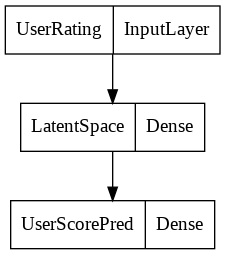

In [27]:
plot_model(AutoRec, to_file='AutoRec.png')

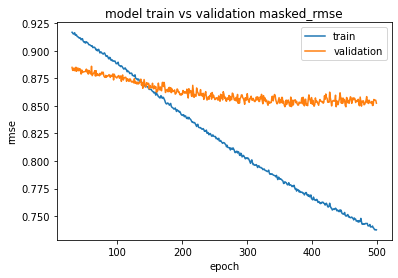

In [28]:
show_rmse(hist_Autorec, 30)

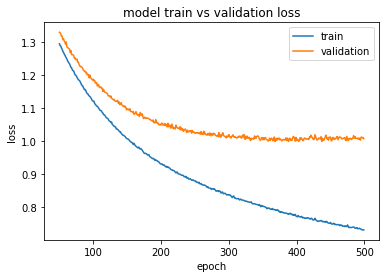

In [29]:
show_error(hist_Autorec, 50)

In [30]:
test_result = AutoRec.evaluate(users_items_matrix_train_average, users_items_matrix_test.astype(float))

189/189 [==============================] - 1s 3ms/step - loss: 1.0145 - masked_rmse_clip: 0.8593


In [31]:
predict_autorec = AutoRec.predict(users_items_matrix_train_zero)

In [32]:
predict_autorec

array([[ 2.9832277 ,  0.5098835 ,  0.20784362, ...,  0.53423613,
         0.18013346,  0.6787848 ],
       [-0.1304767 ,  0.7235192 ,  0.29914427, ...,  0.46010768,
         0.45688114,  1.0426533 ],
       [ 1.4675118 ,  0.4986094 , -0.28844404, ...,  0.40863666,
         0.3484492 ,  0.6988871 ],
       ...,
       [ 0.38108546,  0.27114072,  0.21362044, ...,  0.22235413,
         0.23728782,  0.32502684],
       [ 1.1496545 ,  0.37965026, -0.30812407, ...,  0.43420836,
         0.32530075,  0.24803296],
       [-0.05175198, -0.4625498 , -0.7984715 , ...,  1.0149636 ,
         0.6186758 ,  0.48702148]], dtype=float32)

In [33]:
loss = K.eval(masked_rmse_clip( 
    K.constant((users_items_matrix_train_zero)), 
    K.constant(predict_autorec)))
np.mean(loss)

2.4905853

In [34]:
model_json = AutoRec.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
AutoRec.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [35]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [36]:
loaded_model

In [37]:
from tensorflow.python.keras.optimizer_v2.adam import Adam
optimizer = Adam(learning_rate = 0.001)
loaded_model.compile(optimizer = optimizer, loss=masked_se, metrics=[masked_rmse_clip])
score = loaded_model.evaluate(users_items_matrix_train_zero.astype(float), users_items_matrix_test.astype(float))
score


189/189 [==============================] - 1s 2ms/step - loss: 130.9640 - masked_rmse_clip: 2.6245


[130.96400451660156, 2.624509572982788]

## Deep AE CF

In [38]:
  def Deep_AE_model(X, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, side_infor_size=0):
    '''
    Build Deep AE for CF
        INPUT: 
            X: #_user X #_item matrix
            layers: List, each element is the number of neuron for a layer
            reg: L2 regularization parameter
            activation: activation function for all dense layer except the last
            last_activation: activation function for the last dense layer
            dropout: dropout rate
            regularizer_encode: regularizer for encoder
            regularizer_decode: regularizer for decoder
            side_infor_size: size of the one hot encoding side information
        OUTPUT:
            Keras model
    '''

    # Input
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    
    # Encoder
    # -----------------------------
    k = int(len(layers)/2)
    i = 0
    for l in layers[:k]:
      x = Dense(l, activation=activation,
                      name='EncLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_encode))(x)
      i = i+1
      
      
    # Latent Space
    # -----------------------------
    x = Dense(layers[k], activation=activation, 
                                name='LatentSpace', kernel_regularizer=regularizers.l2(regularizer_encode))(x)
    
    # Dropout
    x = Dropout(rate = dropout)(x)
    
    # Decoder
    # -----------------------------
    for l in layers[k+1:]:
      i = i-1
      x = Dense(l, activation=activation, 
                      name='DecLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_decode))(x)
      
    # Output

    output_layer = Dense(X.shape[1]-side_infor_size, activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(regularizer_decode))(x)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)

    return model

In [39]:
layers = [256, 512, 256]
#layers = [512, 256, 128, 256, 512]
#layers = [512, 256, 512]
#layers = [128, 256, 512, 256, 128]
#layers = [512, 512, 512]
dropout = 0.8
# activation = 'sigmoid'
# last_activation = 'linear'
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

In [40]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=0.0001)
# Build model
Deep_AE = Deep_AE_model(users_items_matrix_train_zero, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
Deep_AE.compile(optimizer = optimizer, loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 EncLayer0 (Dense)           (None, 256)               1011968   
                                                                 
 LatentSpace (Dense)         (None, 512)               131584    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 DecLayer0 (Dense)           (None, 256)               131328    
                                                                 
 UserScorePred (Dense)       (None, 3952)              1015664   
                                                                 
Total params: 2,290,544
Trainable params: 2,290,544
Non-tra

In [41]:
hist_Deep_AE = Deep_AE.fit(x=users_items_matrix_train_zero.astype(float), y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_zero.astype(float), users_items_matrix_validate.astype(float)], verbose=2)

Epoch 1/500
24/24 - 1s - loss: 16.3069 - masked_rmse_clip: 2.8594 - val_loss: 13.8814 - val_masked_rmse_clip: 2.7639 - 1s/epoch - 62ms/step
Epoch 2/500
24/24 - 0s - loss: 11.2227 - masked_rmse_clip: 2.4927 - val_loss: 6.6804 - val_masked_rmse_clip: 1.9293 - 336ms/epoch - 14ms/step
Epoch 3/500
24/24 - 0s - loss: 6.2878 - masked_rmse_clip: 1.8469 - val_loss: 3.8991 - val_masked_rmse_clip: 1.3743 - 314ms/epoch - 13ms/step
Epoch 4/500
24/24 - 0s - loss: 4.3180 - masked_rmse_clip: 1.5021 - val_loss: 3.0674 - val_masked_rmse_clip: 1.1362 - 323ms/epoch - 13ms/step
Epoch 5/500
24/24 - 0s - loss: 3.7179 - masked_rmse_clip: 1.3670 - val_loss: 2.8184 - val_masked_rmse_clip: 1.0593 - 324ms/epoch - 13ms/step
Epoch 6/500
24/24 - 0s - loss: 3.4742 - masked_rmse_clip: 1.3111 - val_loss: 2.6969 - val_masked_rmse_clip: 1.0233 - 325ms/epoch - 14ms/step
Epoch 7/500
24/24 - 0s - loss: 3.3385 - masked_rmse_clip: 1.2820 - val_loss: 2.6163 - val_masked_rmse_clip: 1.0012 - 307ms/epoch - 13ms/step
Epoch 8/500
2

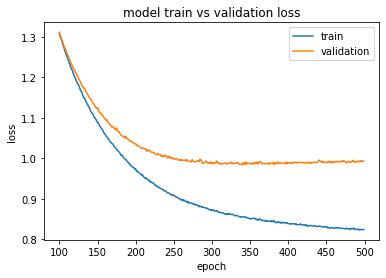

In [42]:
show_error(hist_Deep_AE, 100)

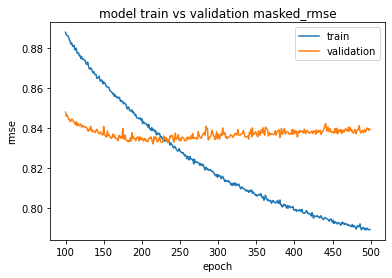

In [43]:
show_rmse(hist_Deep_AE, 100)

In [44]:
predict_deep = Deep_AE.predict(users_items_matrix_train_zero)

In [45]:
test_result_deep = Deep_AE.evaluate(users_items_matrix_train_zero.astype(float), users_items_matrix_test.astype(float))

189/189 [==============================] - 1s 3ms/step - loss: 0.9910 - masked_rmse_clip: 0.8432


In [46]:
loss = K.eval(masked_rmse_clip( 
    K.constant((users_items_matrix_train_zero)), 
    K.constant(predict_deep)))
np.mean(loss)

0.759522

In [47]:
for layer in Deep_AE.layers: 
  print(layer.get_config())

{'batch_input_shape': (None, 3952), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'UserRating'}
{'name': 'EncLayer0', 'trainable': True, 'dtype': 'float32', 'units': 256, 'activation': 'selu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': {'class_name': 'L2', 'config': {'l2': 0.0010000000474974513}}, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
{'name': 'LatentSpace', 'trainable': True, 'dtype': 'float32', 'units': 512, 'activation': 'selu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': {'class_name': 'L2', 'config': {'l2': 0.0010000000474974513}}, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constrain

In [48]:
first_layer_weights = Deep_AE.layers[1].get_weights()[0]

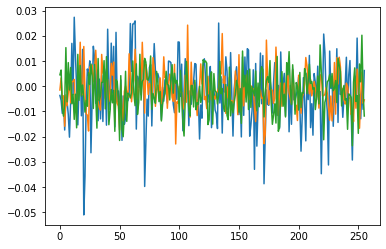

In [49]:
first_layer_weights = Deep_AE.layers[1].get_weights()[0]
plt.plot(np.arange(0, 256, 1), first_layer_weights[0])
plt.plot(np.arange(0, 256, 1), first_layer_weights[1])
plt.plot(np.arange(0, 256, 1), first_layer_weights[2])
plt.show()

## Add Denoise

### Gaussian Noise

#### Gussian AutoRec

In [50]:
## Adding Gaussin noise to input
noise_factor = 0.4
users_items_matrix_train_average_noisy = users_items_matrix_train_average + noise_factor * np.random.normal(size=users_items_matrix_train_zero.shape) 
users_items_matrix_train_zero_noisy = users_items_matrix_train_zero + noise_factor * np.random.normal(size=users_items_matrix_train_zero.shape) 

In [53]:
users_items_matrix_train_average_noisy

array([[5.06186645, 4.9016031 , 4.07974119, ..., 4.6556689 , 3.12616798,
        4.49114915],
       [4.12711283, 3.21173483, 4.67112404, ..., 3.78880302, 3.07134668,
        3.31745695],
       [3.87640363, 4.05957519, 3.86026899, ..., 3.66400007, 3.58248203,
        3.5312853 ],
       ...,
       [4.10834446, 4.29558601, 4.24608875, ..., 3.87241393, 3.99749981,
        3.45625433],
       [4.60373661, 3.64494903, 3.98677205, ..., 3.59702349, 3.76234362,
        3.73701232],
       [4.17614702, 2.96547478, 3.33576451, ..., 3.36458393, 3.2325437 ,
        4.14649918]])

In [55]:

AutoRec = AutoRec(users_items_matrix_train_average_noisy, 0.001 , 'elu' , 'elu')

AutoRec.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])
 
AutoRec.summary()

hist_Autorec = AutoRec.fit(x=users_items_matrix_train_average_noisy, y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_average_noisy, users_items_matrix_validate.astype(float)])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 LatentSpace (Dense)         (None, 500)               1976500   
                                                                 
 UserScorePred (Dense)       (None, 3952)              1979952   
                                                                 
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
24/24 - 1s - loss: 8.3976 - masked_rmse_clip: 1.9095 - val_loss: 4.2820 - val_masked_rmse_clip: 1.2725 - 1s/epoch - 49ms/step
Epoch 2/500
24/24 - 0s - loss: 3.3732 - masked_rmse_clip: 1.1515 - val_loss: 2.8394 - val_masked_rmse_clip: 0.9661 - 333ms/epoch - 14ms/step
Epoch 3/500
24/24 - 0s - loss: 2.6

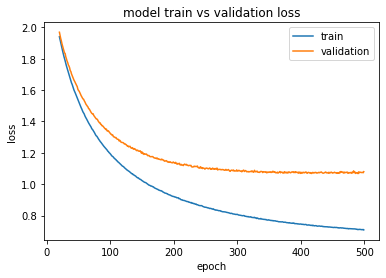

In [56]:
show_error(hist_Autorec, 20)

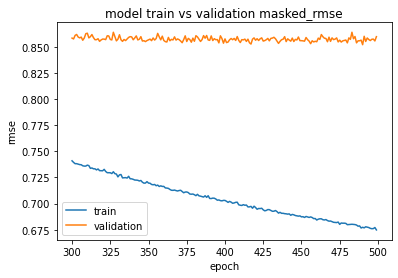

In [57]:
show_rmse(hist_Autorec, 300)

In [58]:
test_result_deep = AutoRec.evaluate(users_items_matrix_train_average_noisy.astype(float), users_items_matrix_test.astype(float))

189/189 [==============================] - 1s 3ms/step - loss: 1.0831 - masked_rmse_clip: 0.8656


#### Gaussian Deep AE CF

In [59]:
layers = [256, 512, 256]
dropout = 0.8

activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

In [60]:
# Build model
Deep_AE_denoise = Deep_AE_model(users_items_matrix_train_zero_noisy, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
Deep_AE_denoise.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE_denoise.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 EncLayer0 (Dense)           (None, 256)               1011968   
                                                                 
 LatentSpace (Dense)         (None, 512)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 DecLayer0 (Dense)           (None, 256)               131328    
                                                                 
 UserScorePred (Dense)       (None, 3952)              1015664   
                                                                 
Total params: 2,290,544
Trainable params: 2,290,544
Non-tra

In [61]:
hist_Deep_AE_denoise = Deep_AE_denoise.fit(x=users_items_matrix_train_zero_noisy.astype(float), y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_zero_noisy.astype(float), users_items_matrix_validate.astype(float)], verbose=2)

Epoch 1/500
24/24 - 1s - loss: 16.4496 - masked_rmse_clip: 2.8569 - val_loss: 14.3662 - val_masked_rmse_clip: 2.7774 - 1s/epoch - 51ms/step
Epoch 2/500
24/24 - 0s - loss: 11.6522 - masked_rmse_clip: 2.5213 - val_loss: 7.2623 - val_masked_rmse_clip: 1.9987 - 339ms/epoch - 14ms/step
Epoch 3/500
24/24 - 0s - loss: 6.9851 - masked_rmse_clip: 1.9196 - val_loss: 4.4649 - val_masked_rmse_clip: 1.5022 - 328ms/epoch - 14ms/step
Epoch 4/500
24/24 - 0s - loss: 4.7952 - masked_rmse_clip: 1.5826 - val_loss: 3.3652 - val_masked_rmse_clip: 1.2080 - 324ms/epoch - 13ms/step
Epoch 5/500
24/24 - 0s - loss: 4.0042 - masked_rmse_clip: 1.4258 - val_loss: 3.0023 - val_masked_rmse_clip: 1.0985 - 319ms/epoch - 13ms/step
Epoch 6/500
24/24 - 0s - loss: 3.6990 - masked_rmse_clip: 1.3503 - val_loss: 2.8496 - val_masked_rmse_clip: 1.0534 - 314ms/epoch - 13ms/step
Epoch 7/500
24/24 - 0s - loss: 3.5385 - masked_rmse_clip: 1.3172 - val_loss: 2.7538 - val_masked_rmse_clip: 1.0251 - 322ms/epoch - 13ms/step
Epoch 8/500
2

In [ ]:
#plot_model(Deep_AE_user, to_file='model.png')

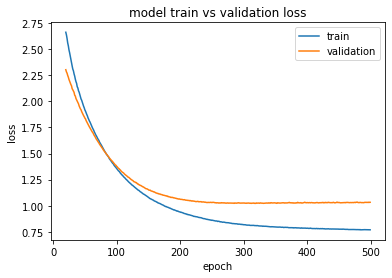

In [62]:
show_error(hist_Deep_AE_denoise, 20)

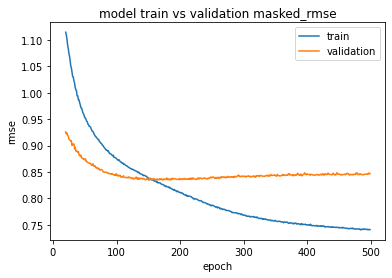

In [63]:
show_rmse(hist_Deep_AE_denoise, 20)

In [64]:
test_result_deep = Deep_AE_denoise.evaluate(users_items_matrix_train_zero_noisy.astype(float), users_items_matrix_test.astype(float))

189/189 [==============================] - 1s 3ms/step - loss: 1.0287 - masked_rmse_clip: 0.8519


In [65]:
predict_deep = Deep_AE_denoise.predict(users_items_matrix_train_zero_noisy)
loss = K.eval(masked_rmse_clip( 
    K.constant((users_items_matrix_train_zero)), 
    K.constant(predict_deep)))
np.mean(loss)

0.7044084

### Dropout Noise

In [66]:
  def Deep_AE_DropNoise_model(X, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, noise):
    '''
    Build Deep AE for CF
    '''

    # Input
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    
    # Dropout Noise
    x = Dropout(rate = noise)(x)
    
    # Encoder
    # -----------------------------
    k = int(len(layers)/2)
    i = 0
    for l in layers[:k]:
      x = Dense(l, activation=activation,
                      name='EncLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_encode))(x)
      i = i+1
      
      
    # Latent Space
    # -----------------------------
    x = Dense(layers[k], activation=activation, 
                                name='LatentSpace', kernel_regularizer=regularizers.l2(regularizer_encode))(x)
    
    # Dropout
    x = Dropout(rate = dropout)(x)
    
    # Decoder
    # -----------------------------
    for l in layers[k+1:]:
      i = i-1
      x = Dense(l, activation=activation, 
                      name='DecLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_decode))(x)
    # Output

    output_layer = Dense(X.shape[1], activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(regularizer_decode))(x)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)

    return model

In [67]:
layers = [256, 512, 256]
dropout = 0.8
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001
dropN = 0.1
# Build model
Deep_AE_denoise_dropN = Deep_AE_DropNoise_model(users_items_matrix_train_zero, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, dropN)
Deep_AE_denoise_dropN.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE_denoise_dropN.summary()
hist_Deep_AE_denoise_dropN = Deep_AE_denoise_dropN.fit(x=users_items_matrix_train_zero.astype(float), y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_zero.astype(float), users_items_matrix_validate.astype(float)], verbose=2)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 dropout_2 (Dropout)         (None, 3952)              0         
                                                                 
 EncLayer0 (Dense)           (None, 256)               1011968   
                                                                 
 LatentSpace (Dense)         (None, 512)               131584    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 DecLayer0 (Dense)           (None, 256)               131328    
                                                                 
 UserScorePred (Dense)       (None, 3952)              1015

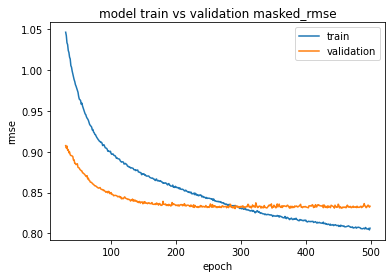

In [68]:
show_rmse(hist_Deep_AE_denoise_dropN, 30)

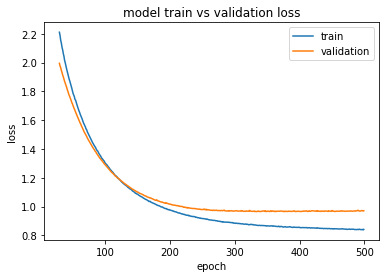

In [69]:
show_error(hist_Deep_AE_denoise_dropN, 30)

In [70]:
test_result_deep = Deep_AE_denoise_dropN.evaluate(users_items_matrix_train_zero.astype(float), users_items_matrix_test.astype(float))

189/189 [==============================] - 1s 3ms/step - loss: 0.9706 - masked_rmse_clip: 0.8381
